In [26]:
%load_ext autoreload
%autoreload 2
import sys
from os import path as pt
sys.path.append('../src')
import warnings
# ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
sns.set_theme()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed = 42
rng = np.random.default_rng(seed)
rng_idx = rng.integers(0, 114, size=10000)
rng_idx

array([10, 88, 74, ..., 40, 64, 70])

In [3]:
positions = []
indices = []
for i in range(114):
    position = np.where(rng_idx == i)[0]
    positions.append(position)
    indices.append(position[rng.integers(0, len(position))])
indices = np.array(indices)
indices

array([2645, 3135, 5161, 6760, 2629, 7189, 5645, 2330, 9418,  216, 5534,
       4182, 6463, 7097, 7203, 6471, 7943, 6870, 7744, 3558, 1928, 2928,
       5780, 5493, 1987, 3180, 9633, 7382, 7326, 2420,  617, 3795, 8840,
       4770, 7139, 5320, 5707, 5767, 9451, 4191, 6433, 9260, 3107, 7712,
       5332, 9389, 5195, 5728, 4034, 6643, 3600, 5663, 7767, 4706, 3989,
       4414, 6806, 5949, 5860,  448, 1334,  288, 8790, 8457,  979,  569,
       8127, 6003, 3006, 5967, 2416, 2127, 2757, 9238, 7954, 2021, 5535,
       9161, 9714, 7925, 1316, 3445, 1749, 1231, 1393, 3166, 5688, 3846,
       3000, 1725, 1616, 9966, 6811, 2337, 7431, 7563, 9597, 1291, 6726,
       9828, 8395, 2041, 8757, 4514, 5191, 4978, 7054, 1836, 4601, 7559,
       4581, 2626, 1087, 5841])

In [4]:
hist_len = 50
df_spx = pd.read_csv('../data/spx_20231229.csv', index_col=0, parse_dates=True)
df_spx = df_spx.loc['1995-02-01':'2022-10-19']
batches = sliding_window_view(df_spx['spx'], 300)[::50]
dt_batches = sliding_window_view(df_spx.index, 300)[::50]
spx_log_returns = []
spx_log_path = []
time_dim = []
for idx in rng_idx:
    returns = np.diff(np.log(batches[idx, hist_len:]), axis=0)
    log_path = np.zeros((len(returns)+1), dtype=np.float32)
    log_path[1:] = returns.cumsum()
    dt = pd.Series(dt_batches[idx, hist_len:]).diff().dropna().dt.days / 365
    time = torch.zeros(len(dt)+1, dtype=torch.float32, requires_grad=False)
    time[1:] = torch.tensor(dt.values, dtype=torch.float32, requires_grad=False).cumsum(dim=0)
    time_dim.append(time)
    spx_log_returns.append(returns)
    spx_log_path.append(log_path)
spx_log_returns = np.array(spx_log_returns)
time_dim = torch.tensor(np.array(time_dim), dtype=torch.float32, requires_grad=False).unsqueeze(-1)
spx_log_path = torch.tensor(np.array(spx_log_path), dtype=torch.float32, requires_grad=False).unsqueeze(-1)
spx_log_path = torch.cat([time_dim, spx_log_path], dim=-1)
spx_log_path = spx_log_path[indices]
spx_log_returns.shape, time_dim.shape, spx_log_path.shape

((10000, 249), torch.Size([10000, 250, 1]), torch.Size([114, 250, 2]))

torch.Size([114, 250, 2])

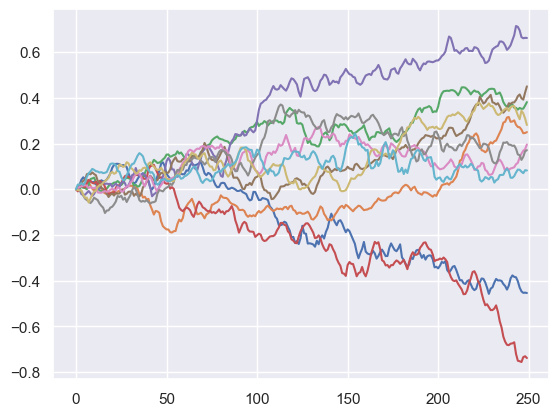

In [5]:
cotgan_log_returns = torch.tensor(torch.load('../data/cotgan_r_aligned_noise.pt', map_location='cpu', weights_only=False), dtype=torch.float32, requires_grad=False)
cotgan_log_path = torch.zeros(cotgan_log_returns.shape[0], cotgan_log_returns.shape[1]+1, 1, device='cpu')
cotgan_log_path[:, 1:, 0] = cotgan_log_returns.cumsum(dim=1)
cotgan_log_path = torch.cat([time_dim, cotgan_log_path], dim=2)
plt.plot(cotgan_log_path[:10, :, 1].T);
cotgan_log_path = cotgan_log_path[indices]
cotgan_log_path.shape

torch.Size([114, 250, 2])

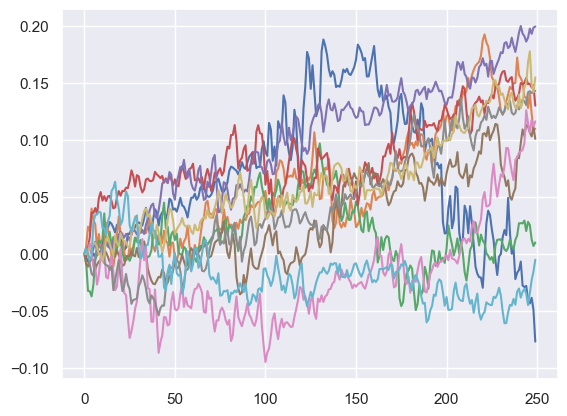

In [6]:
mmd_log_returns = torch.load('../data/mmd_r_aligned_noise.pt', map_location='cpu', weights_only=False)
mmd_log_path = torch.zeros(mmd_log_returns.shape[0], mmd_log_returns.shape[1]+1, 1, device='cpu')
mmd_log_path[:, 1:, 0] = mmd_log_returns.cumsum(dim=1)
mmd_log_path = torch.cat([time_dim, mmd_log_path], dim=2)
plt.plot(mmd_log_path[:10,:,1].T);
mmd_log_path = mmd_log_path[indices]
mmd_log_path.shape

torch.Size([114, 250, 2])

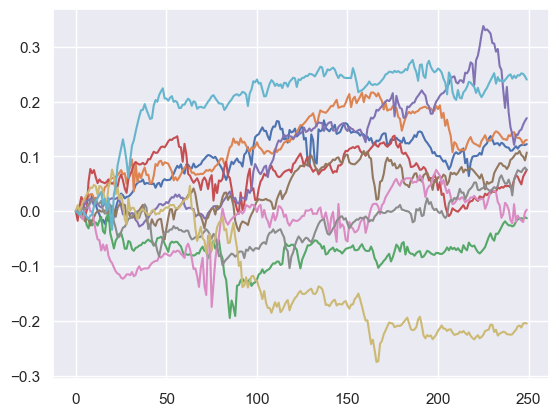

In [7]:
csigwgan_paths = torch.load('../data/csigwgan_paths_p3_q3.pt', map_location='cpu', weights_only=False)
csigwgan_log_path = torch.log(csigwgan_paths)
plt.plot(csigwgan_log_path[:10].T);
csigwgan_log_path = torch.cat([time_dim, csigwgan_log_path.unsqueeze(-1)], dim=2)
csigwgan_log_path = csigwgan_log_path[indices]
csigwgan_log_path.shape

torch.Size([114, 250, 2])

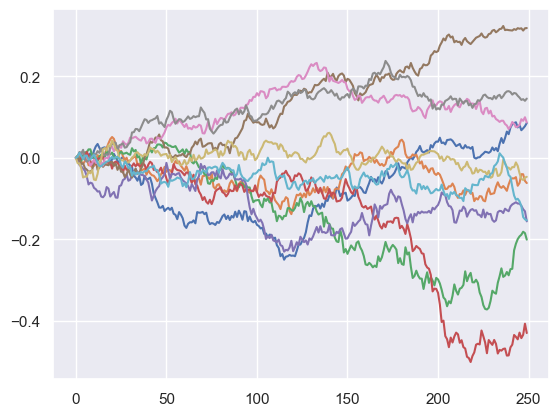

In [8]:
nsde_log_returns = torch.load('../data/SPX_250_38_1_sigker_mmd_1.0.pt', map_location='cpu', weights_only=False)
nsde_log_path = torch.zeros(nsde_log_returns.shape[0], nsde_log_returns.shape[1]+1, 1, device='cpu')
nsde_log_path[:, 1:, 0] = nsde_log_returns.cumsum(dim=1)
nsde_log_path = torch.cat([time_dim, nsde_log_path], dim=2)
plt.plot(nsde_log_path[:10,:,1].T);
nsde_log_path = nsde_log_path[indices]
nsde_log_path.shape

In [ ]:
import os
model_dir = "../trained_models/Hestonprice_timestep_60/model_InfoCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_None/InfoCVAE_training_2024-09-16_18-19-18/final_model"
os.makedirs(model_dir,exist_ok=True)

In [10]:
from evaluations.hyperparameter import ModelEvaluator
from tsvae.utils.random_utils import set_seed
model_evaluator = ModelEvaluator(model_dir)
output_dir = model_evaluator.hyper_model_dir
model = model_evaluator.model

test_data, gen_data, recon_data = model_evaluator.load_data(seed = 99)
ds = model_evaluator.data_ppl.base_dataset

real_data = test_data
recon_data = recon_data
fake_data = gen_data

Base dataset initialized


C_hidden_dim: 0
C_input_dim: 0
C_num_layers: 0
C_output_dim: 0
D_hidden_dim: 16
D_input_dim: 2
D_num_layers: 2
D_output_dim: 1
E_hidden_dim: 16
E_input_dim: 1
E_num_layers: 2
E_output_dim: 2
P_hidden_dim: 250
P_latent_dim: null
P_num_flows: 3
alpha: 0.8
base_output_dir: /u/hous/tc-vae/userdata
beta: 0.08
comment: null
condition_dim: 1
conditioner: Id
data_dim: 1
data_length: 60
dataset: Hestonprice
decoder: CLSTMRes
discriminator: null
encoder: CLSTMRes
epochs: 500
eval_batch_size: 256
inv_transform: exp
latent_dim: 2
latent_length: 60
lr: 0.001
model: InfoCVAE
n_sample: 2560
n_timestep: 60
optimizer: Adam
output_dir: /u/hous/tc-vae/userdata/results/Hestonprice_timestep_60/model_InfoCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_None
prior: RealNVP
seed: 0
steps_predict: 20
steps_saving: 20
train_batch_size: 256
transform: log
wandb: true



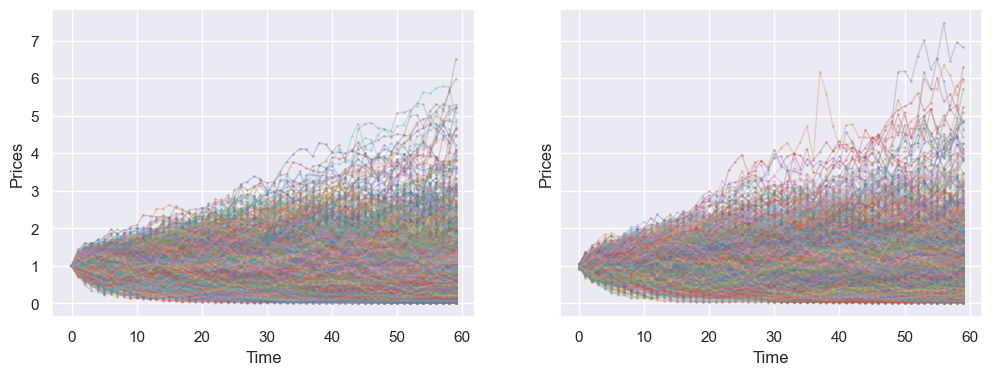

In [11]:
from evaluations.compare import compare_path
compare_path(real_data,fake_data)

In [ ]:
from evaluations.compare import compare_corr, compare_path, compare_marginal_hist, compare_noised_paths
import seaborn as sns
sns.set_theme()

file_path = pt.join(output_dir, 'prices_real_fake.png')
compare_path(real_data, fake_data, ['Real', 'Fake'], file_path)

file_path = pt.join(output_dir, 'prices_real_recon.png')
compare_path(real_data, recon_data, ['Real', 'Recon'], file_path)

file_path = pt.join(output_dir, 'marginal_real_fake.png')
compare_marginal_hist(real_data, fake_data, file_path = file_path)

file_path = pt.join(output_dir, 'correlation.png')
compare_corr(real_data, fake_data, file_path=file_path)


(tensor(1.), tensor(1.))

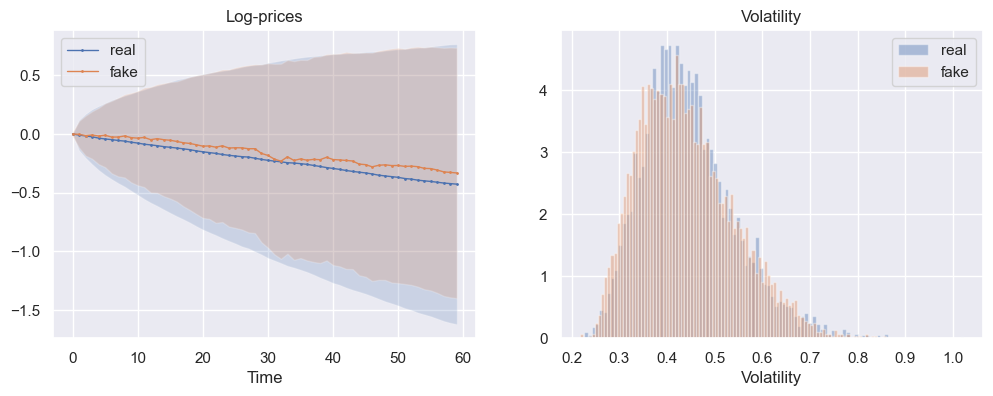

In [6]:
from evaluations.eval_drift_vol import compare_drift_volatility
file_path = pt.join(output_dir, 'drift_volatility.png')
compare_drift_volatility(real_data, fake_data, T = ds.dt * ds.n_timestep, file_path = file_path)

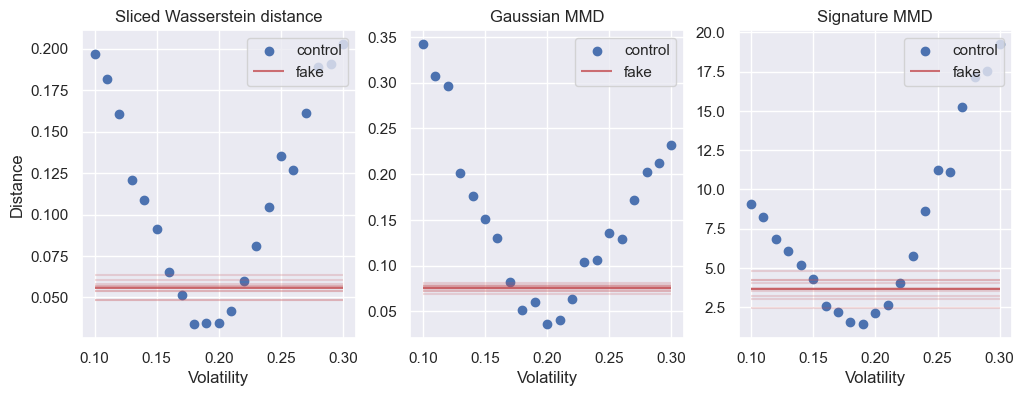

In [7]:
from evaluations.eval_uncon import load_data_eval_dist_uncon, compute_eval_dist_uncon, plot_eval_dist_uncon
fake_data_list, control_data_dict = load_data_eval_dist_uncon(model_evaluator)

mmd_control_dist, mmd_fake_dist = compute_eval_dist_uncon(real_data, fake_data_list, control_data_dict, 'mmd', output_dir)
swd_control_dist, swd_fake_dist = compute_eval_dist_uncon(real_data, fake_data_list, control_data_dict, 'swd', output_dir)
esig_control_dist, esig_fake_dist = compute_eval_dist_uncon(real_data, fake_data_list, control_data_dict, 'esig', output_dir)

file_path = pt.join(output_dir, 'mmd_swd_esig.png')
plot_eval_dist_uncon(
    mmd_control_dist,
    mmd_fake_dist,
    swd_control_dist,
    swd_fake_dist,
    esig_control_dist,
    esig_fake_dist,
    plot_file_path=file_path,
)

In [8]:
from evaluations.eval_os import load_os_data, compare_os
r = ds.mu
dt = ds.dt
s0, strike = 100, 100
n_maturity_timestep = 12
n_sample_test = 5000

real_data_list, fake_data_list, control_data_dict = load_os_data(model_evaluator, s0, n_maturity_timestep, n_sample_test)


100%|██████████| 21/21 [00:00<00:00, 36.30it/s]


100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


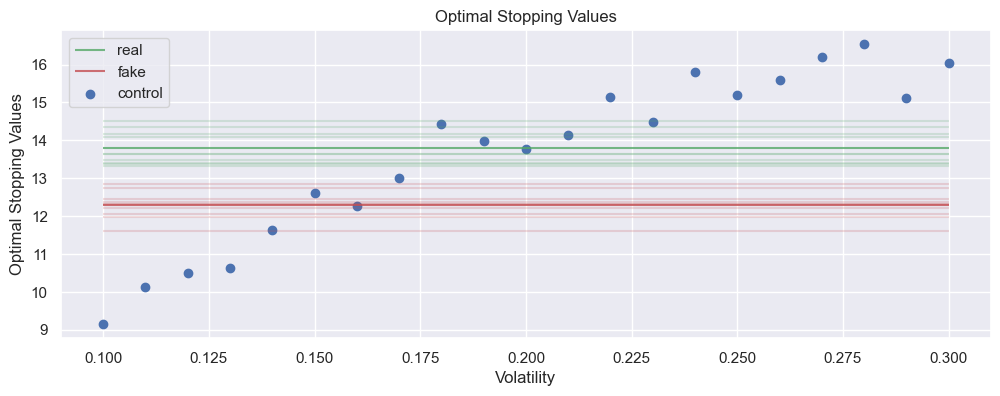

In [9]:
file_path = pt.join(output_dir, 'optimal_stopping.png')
compare_os(r,s0,n_maturity_timestep,dt,strike,real_data_list,fake_data_list,control_data_dict,file_path=file_path)

In [12]:
from copy import deepcopy
from evaluations.eval_uncon import compute_eval_awd_dist_uncon, plot_eval_awd_dist_uncon
sigma = 0.3
exp_config = deepcopy(model_evaluator.exp_config)
exp_config.n_sample = len(real_data)
control_data, label = model_evaluator.data_ppl._get_data_label(exp_config, control = sigma)

realreal
mean: 0.07703291584605973
std: 0.006805176167977613
realfake
mean: 0.13301922711433203
std: 0.010299526902851951
realcontrol
mean: 0.1529893436542872
std: 0.009538296403810641


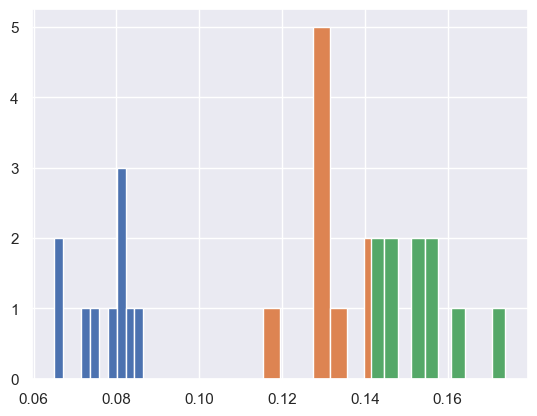

In [ ]:
sawd_dist_dict = compute_eval_awd_dist_uncon(spx_log_path[:,:,1:], mmd_log_path[:,:,1:], nsde_log_path[:,:,1:], './')
plot_eval_awd_dist_uncon(sawd_dist_dict, output_dir)

 10%|█         | 1/10 [00:12<01:52, 12.52s/it]

Real-Real: 0.08
Real-Fake: 0.31
Real-Control: 0.15


 20%|██        | 2/10 [00:24<01:38, 12.29s/it]

Real-Real: 0.08
Real-Fake: 0.26
Real-Control: 0.14


 30%|███       | 3/10 [00:36<01:26, 12.30s/it]

Real-Real: 0.08
Real-Fake: 0.29
Real-Control: 0.13


 40%|████      | 4/10 [00:49<01:14, 12.40s/it]

Real-Real: 0.08
Real-Fake: 0.29
Real-Control: 0.13


 50%|█████     | 5/10 [01:02<01:02, 12.48s/it]

Real-Real: 0.08
Real-Fake: 0.26
Real-Control: 0.15


 60%|██████    | 6/10 [01:14<00:49, 12.46s/it]

Real-Real: 0.07
Real-Fake: 0.29
Real-Control: 0.13


 70%|███████   | 7/10 [01:27<00:37, 12.49s/it]

Real-Real: 0.09
Real-Fake: 0.33
Real-Control: 0.13


 80%|████████  | 8/10 [01:40<00:25, 12.63s/it]

Real-Real: 0.07
Real-Fake: 0.27
Real-Control: 0.14


 90%|█████████ | 9/10 [01:52<00:12, 12.62s/it]

Real-Real: 0.08
Real-Fake: 0.27
Real-Control: 0.13


100%|██████████| 10/10 [02:05<00:00, 12.51s/it]

Real-Real: 0.07
Real-Fake: 0.29
Real-Control: 0.14
realreal
mean: 0.0791647129504386
std: 0.006977203414717614
realfake
mean: 0.28541228341429525
std: 0.02037961543938288
realcontrol
mean: 0.1370399003083695
std: 0.007375700510132791


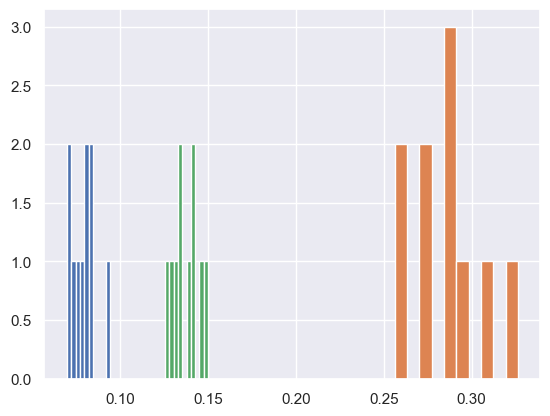

In [35]:
sawd_dist_dict = compute_eval_awd_dist_uncon(spx_log_path[:,:,1:], cotgan_log_path[:,:,1:], csigwgan_log_path[:,:,1:], './')
plot_eval_awd_dist_uncon(sawd_dist_dict, output_dir)

realreal
mean: 0.5002343768593057
std: 0.04532849129847897
realfake
mean: 0.5388170020304374
std: 0.04358385917836554
realcontrol
mean: 0.717504173238448
std: 0.04603860903484326


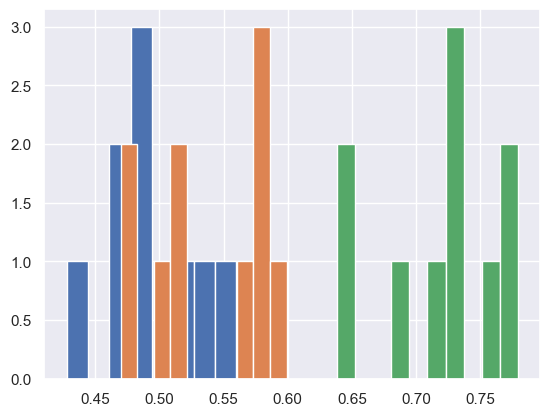

In [11]:
sawd_dist_dict = compute_eval_awd_dist_uncon(real_data, fake_data, control_data, output_dir)
plot_eval_awd_dist_uncon(sawd_dist_dict, output_dir)